In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-retirement/Bank_Customer_retirement.csv


# Problem Statement

This notebook seeks to predict the eligibility of bank customers to retire, based on numerous user features. SVM models are used for this purpose.

# Step 1: Import packages and datasets

In [2]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../input/bank-customer-retirement/Bank_Customer_retirement.csv')
data.head()

,Customer ID,Age,401K Savings,Retire
0,0,39.180417,322349.8740,0
1,1,56.101686,768671.5740,1
2,2,57.023043,821505.4718,1
3,3,43.711358,494187.4850,0
4,4,54.728823,691435.7723,1


In [4]:
data.tail()

,Customer ID,Age,401K Savings,Retire
495,495,46.678128,704243.0776,1
496,496,43.545007,483175.9998,0
497,497,46.476724,354919.1987,0
498,498,50.903631,639789.9219,1
499,499,38.590586,491310.0096,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Customer ID   500 non-null    int64  
 1   Age           500 non-null    float64
 2   401K Savings  500 non-null    float64
 3   Retire        500 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 15.8 KB


There is no missing values in the dataset. All variables are in the correct format.

# Step 2: Exploratory Data Analysis

Answer the following questions:
* How many customers are retired and how many are not?
* What is the distribution of age (by retirement)?
* What is the distribution of 401K Savings (by retirement)?

In [6]:
#Retirement
print("The total number of customers in this dataset is: ", len(data))
print("Out of those customers, the number of retired customers is: ", len(data[data['Retire']==1]))
print("Out of those customers, the number of not retired customers is: ", len(data[data['Retire']==0]))

The total number of customers in this dataset is:  500
Out of those customers, the number of retired customers is:  250
Out of those customers, the number of not retired customers is:  250


The dataset is very balanced between retired and non-retired customers.

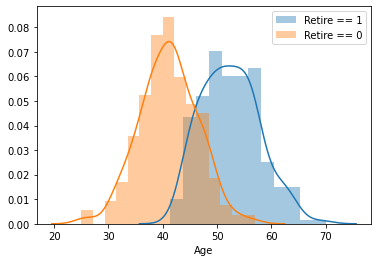

In [7]:
#Distribution of age
sns.distplot(data[data['Retire']==1]['Age'], label = 'Retire == 1')
sns.distplot(data[data['Retire']==0]['Age'], label = 'Retire == 0')
plt.legend()
plt.show()

Intuitively, retired customers on average are older than non-retired customers. Most retired customers are in the 50-58 interval.

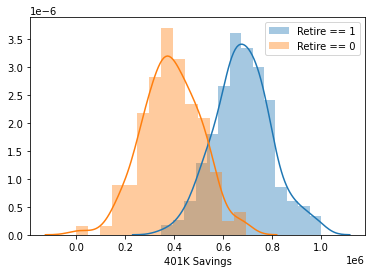

In [8]:
#Distribution of 401k savings
sns.distplot(data[data['Retire']==1]['401K Savings'], label = 'Retire == 1')
sns.distplot(data[data['Retire']==0]['401K Savings'], label = 'Retire == 0')
plt.legend()
plt.show()

Intuitively, on average retired customers have higher savings than non-retired customers.

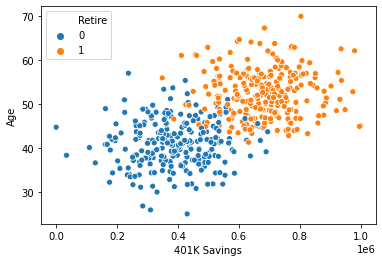

In [9]:
#Scatterplot
sns.scatterplot(data = data, x = '401K Savings', y = 'Age', hue = 'Retire')

Support Vector Machine seems to be a great classifier based on the scatterplot.

# Step 3: Data Cleaning and Model Training

Previously we've seen that this dataset does not have missing values. The applicable data cleaning steps include:
* Normalizing the variables, as 401K Savings and Age are on very different scales
* Drop useless columns, e.g. Customer ID
* Separate dataset into dependent and independent variables

In [10]:
#Drop customer ID
data = data.drop(['Customer ID'], axis = 1)
data.head()

,Age,401K Savings,Retire
0,39.180417,322349.8740,0
1,56.101686,768671.5740,1
2,57.023043,821505.4718,1
3,43.711358,494187.4850,0
4,54.728823,691435.7723,1


In [11]:
#Split into X and y
X = data.drop(['Retire'], axis = 1)
y = data['Retire']

In [12]:
#Normalize X
X_min = X.min()
X_range = (X - X_min).max()
X_scaled = (X - X_min)/X_range

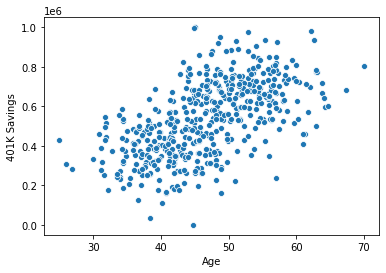

In [13]:
#Inspect normalization
sns.scatterplot(data = X, x = 'Age', y = '401K Savings')

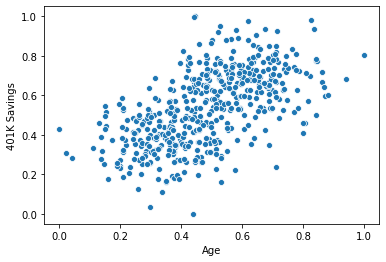

In [14]:
sns.scatterplot(data = X_scaled, x = 'Age', y = '401K Savings')

In [15]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 42)

In [16]:
#Fit model
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [17]:
#Evaluate model
y_pred = svc_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        55
           1       0.99      0.97      0.98        70

    accuracy                           0.98       125
   macro avg       0.97      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



Text(33.0, 0.5, 'Predicted Value')

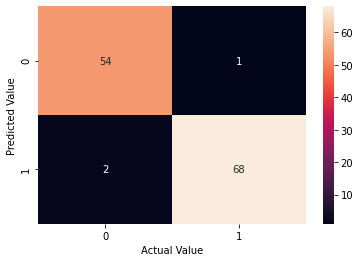

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

The model accuracy is ~97%. We can try to improve the results further using GridSearchCV.

# Step 4: Model Improvement Using Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
#specify parameters and instantiate grid search cv
params = {'C': [0.1, 1, 10, 100],
         'gamma': [0.1, 1, 10, 100],
         'kernel': ['linear', 'rbf']}
gs = GridSearchCV(SVC(), params)

In [21]:
#fit gs
gs.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']})

In [22]:
gs.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [23]:
#move the range of C leftwards to check validity
params_1 = {'C': [0.001, 0.01, 0.1, 1],
         'gamma': [0.1, 1, 10, 100],
         'kernel': ['linear', 'rbf']}
gs_1 = GridSearchCV(SVC(), params_1)

In [24]:
gs_1.fit(X_train, y_train)
gs_1.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

The best selection of parameters will be {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [25]:
#predict based on gs
y_pred_gs1= gs_1.predict(X_test)

In [26]:
#evaluate gs results
print(classification_report(y_test, y_pred_gs1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        55
           1       0.99      0.97      0.98        70

    accuracy                           0.98       125
   macro avg       0.97      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



Text(33.0, 0.5, 'Predicted Value')

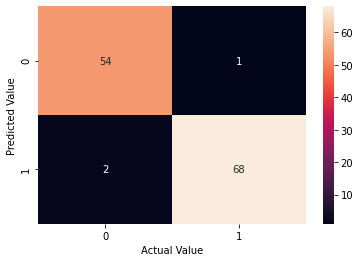

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred_gs1), annot = True)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

The model accuracy stays at ~97%.